# Final Project: Landslide Exposure of Building Infrastructures in Portland, OR 

Daniel Acosta, 2021  
CEWA 599  
Instructor: David Shean  

## Background
Based on the quantitative landslide risk equation, which is defined as risk as a function of annual probability of landslide (hazard), the spatial and spatial-time probability of a landslide impacting a building (runout and exposure), and the probability of injury or death from a given impact by a landslide (vulnerability). In this sense, a landslide exposure is defined as the analysis of elements at risk of being prone to a hazardous zone. The elements at risk refer to building footprints that match specific susceptibility classes.

Given a landslide susceptibility map, often landslide exposure has been measured using land cover maps for further risk assessment. However, a detailed landslide exposure analysis using building footprint maps is scarce. For this reason, this project explores some ways building footprint data can be utilized to assess landslide exposure in Portland, Oregon, with a focus on building infrastructures. Further research can include social and economical features of the building zones.

## Problem Statement
What is the landslide exposure of building infrastructure in the city of Portland, Oregon? The dataset to be used are:

* Landslide Susceptibility maps
* Building Footprint data

## Objective  
* Load raster data of landslide susceptibility (LS) map of Portland, Oregon
* Load the building data of Portland, Oregon
* Load the Portland neighborhood boundaries 
* Compute the LS level for each building
* Compute the landslide exposure as the area of all buildings under different LS levels

## Tools
* GDAL
* Rasterio
* NumPy
* Matplotlib

## Tools

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [2]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [3]:
%matplotlib inline

In [ ]:
# Define projection: Using Alber Equal Area for Western US
proj = '+proj=aea +lat_1=34.999455 +lat_2=48.999727 +lat_0=41.999590999999995 +lon_0=-114.267371'

## Part 1: Loading raster data  
Using Raster basic to open downloaded image from disk

In [4]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [5]:
path = r'project_data/Portland_LSM.tif'

In [6]:
with rio.open(path) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 3196, 'height': 2532, 'count': 1, 'crs': CRS.from_epsg(2994), 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
       0.0, -32.808398933649286, 1431484.1683), 'tiled': False, 'interleave': 'band'}


In [7]:
ls = rio.open(path)

In [8]:
ls.count

1

In [9]:
ls.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 3196,
 'height': 2532,
 'count': 1,
 'crs': CRS.from_epsg(2994),
 'transform': Affine(32.80839896745932, 0.0, 704567.5157,
        0.0, -32.808398933649286, 1431484.1683)}

In [10]:
a = ls.read(1)

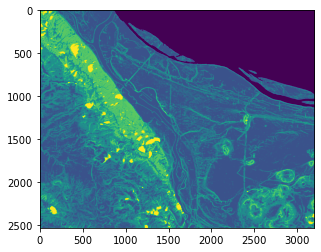

In [11]:
f, ax=plt.subplots()
ax.imshow(a);

### Open raster data into NumPy array

In [12]:
im = gdal.Open(path)
gdal_im = im.GetRasterBand(1)
r = gdal_im.ReadAsArray()
r

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

In [13]:
with rio.open(path) as red:
    r1 = red.read(1)
r1

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 3, 2, 2],
       [1, 1, 2, ..., 3, 3, 2],
       [1, 1, 1, ..., 3, 3, 2]], dtype=uint16)

### Eliminate nondata values

In [14]:
import numpy.ma as ma
mask = ma.masked_equal(r, 0)
mask

masked_array(
  data=[[3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        [3, 3, 3, ..., --, --, --],
        ...,
        [2, 2, 2, ..., 3, 2, 2],
        [1, 1, 2, ..., 3, 3, 2],
        [1, 1, 1, ..., 3, 3, 2]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16)

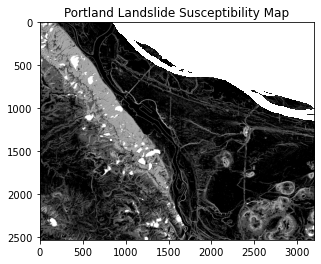

In [15]:
f, ax = plt.subplots()
ax.imshow(mask, cmap = 'gray')
ax.set_title('Portland Landslide Susceptibility Map');

### Histogram of raster data

In [16]:
ls_masked = np.ravel(mask)
ls_masked

masked_array(data=[3, 3, 3, ..., 3, 3, 2],
             mask=[False, False, False, ..., False, False, False],
       fill_value=0,
            dtype=uint16)

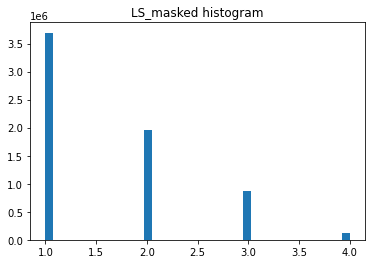

In [17]:
plt.hist(ls_masked, bins = 40)
plt.title('LS_masked histogram')
plt.show()

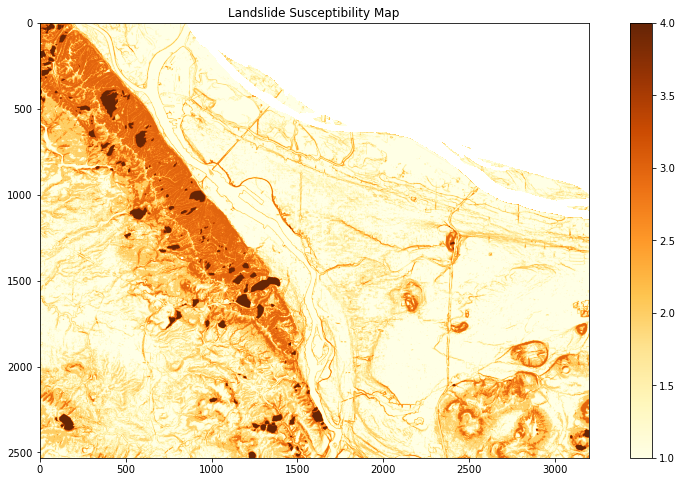

In [245]:
# Plot with coloramp
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
lsmap = ax.imshow(mask, cmap='YlOrBr')
f.colorbar(lsmap, ax=ax)
ax.set_title('Landslide Susceptibility Map');

## Part 2: Loading Portland neighborhood boundaries polygons  
Using rasterio to load vector data

In [19]:
%pwd

'/home/jovyan/landslide_exposure_portland'

In [20]:
neigh = 'project_data/portland_neighborhoods_boundaries.gpkg'

In [21]:
n = gpd.read_file(neigh)
n

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,ID,geometry
0,1,LINNTON,None,N,NWNW,HORZ,52741.719772,Linnton,1,"MULTIPOLYGON (((-13672672.739 5717458.926, -13..."
1,2,FOREST PARK/LINNTON,None,Y,NWNW,None,57723.635350,Forest Park/Linnton,2,"MULTIPOLYGON (((-13672615.072 5717458.598, -13..."
2,3,FOREST PARK,None,N,NWNW,HORZ,82725.497522,Forest Park,3,"MULTIPOLYGON (((-13669096.892 5708277.357, -13..."
3,4,CATHEDRAL PARK,None,N,NPNS,HORZ,11434.254777,Cathedral Park,4,"MULTIPOLYGON (((-13666093.373 5714122.821, -13..."
4,5,UNIVERSITY PARK,None,N,NPNS,HORZ,11950.859827,University Park,5,"MULTIPOLYGON (((-13663193.115 5713925.450, -13..."
...,...,...,...,...,...,...,...,...,...,...
125,126,KENTON,ALBINA,N,NPNS,HORZ,19247.188225,Kenton,126,"MULTIPOLYGON (((-13656518.251 5712854.259, -13..."
126,127,BRIDGETON,None,N,NPNS,HORZ,8635.720662,Bridgeton,127,"MULTIPOLYGON (((-13654119.219 5716859.597, -13..."
127,128,EAST COLUMBIA,None,N,NPNS,HORZ,15397.269131,East Columbia,128,"MULTIPOLYGON (((-13654465.933 5716396.064, -13..."
128,129,SUNDERLAND ASSOCIATION OF NEIGHBORS,None,N,CNN,HORZ,20706.496916,Sunderland,129,"MULTIPOLYGON (((-13652256.730 5716663.111, -13..."


In [22]:
n.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

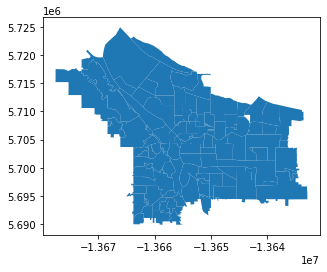

In [23]:
n.plot()

In [25]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [26]:
src = rio.open(path)
proj_fn = os.path.splitext(path)[0]+'_utm_riowarp.tif'
rio_reproj_write(src, proj_fn, proj)

File exists:  project_data/Portland_LSM_utm_riowarp.tif


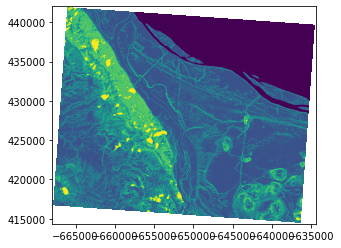

In [27]:
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

In [28]:
#Load as a masked array
src_proj = rio.open(proj_fn)
ls_proj = src_proj.read(1, masked=True)

In [29]:
# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(src_proj)

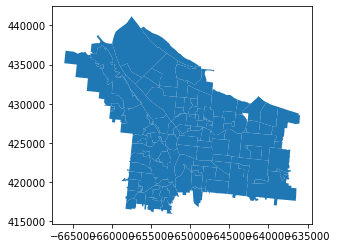

In [30]:
# Reprojecting neighborhood boundaries
n_rp = n.to_crs(proj)

# Plotting
n_rp.plot();

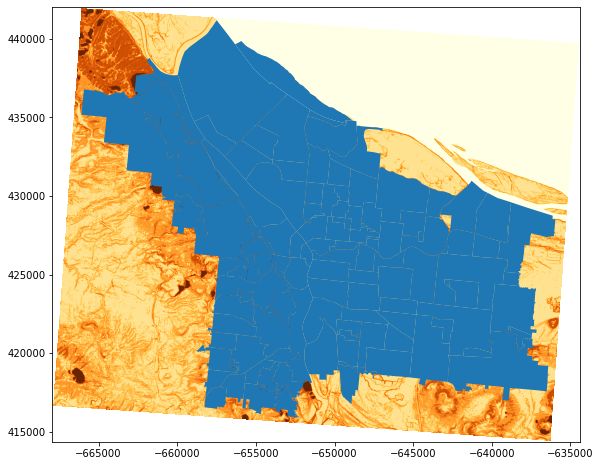

In [31]:
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_proj, cmap='YlOrBr', extent=ls_extent)
n_rp.plot(ax=ax);

In [32]:
# Geometry variable
po_geom = n_rp.geometry
po_geom

0      MULTIPOLYGON (((-662543.186 436406.621, -66251...
1      MULTIPOLYGON (((-662503.227 436402.413, -66249...
2      MULTIPOLYGON (((-660700.674 429737.936, -66077...
3      MULTIPOLYGON (((-658212.026 433621.397, -65850...
4      MULTIPOLYGON (((-656213.977 433284.861, -65597...
                             ...                        
125    MULTIPOLYGON (((-651657.194 432081.004, -65192...
126    MULTIPOLYGON (((-649719.500 434719.891, -64932...
127    MULTIPOLYGON (((-649991.577 434419.210, -64994...
128    MULTIPOLYGON (((-648441.257 434456.601, -64839...
129    MULTIPOLYGON (((-653842.241 433138.803, -65392...
Name: geometry, Length: 130, dtype: geometry

In [33]:
# Clip for Portland Nieghborhoods
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
po_ma, po_ma_transform = rio.mask.mask(src_proj, po_geom, **rio_mask_kwargs)

In [34]:
po_ma.shape

(2531, 3019)

In [35]:
po_ma_transform

Affine(9.983754460045162, 0.0, -666094.3467535608,
       0.0, -9.983754460045162, 441173.58416498365)

In [36]:
#Get clipped extent in UTM coordaintes
po_ma_extent = rio.plot.plotting_extent(po_ma, po_ma_transform)
po_ma_extent

(-666094.3467535608,
 -635953.3920386845,
 415904.70162660937,
 441173.58416498365)

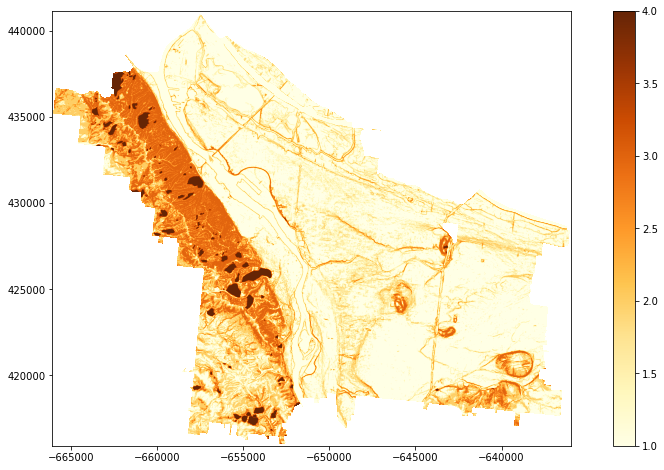

In [37]:
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax);

## Part 3: Loading building footprint

In [38]:
bfoot = 'project_data/portland_building_footprint.gpkg'

In [39]:
b = gpd.read_file(bfoot)
b

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,OBJECTID,BLDG_ID,STATE_ID,BLDG_NUMB,BLDG_STAT,BLDG_NAME,BLDG_ADDR,BLDG_TYPE,BLDG_USE,BLDG_SQFT,...,ORIENT,VOLUME,Shape_Leng,Shape_Area,PROPKEY,EDIT_STAT,DATA_SOURC,RETIRED_BY,RETIRED_DA,geometry
0,80,1N1W01DA-7900-B1,1N1W01DA 7900,1.0,EXISTING,8135 N OLYMPIA ST,8135 N OLYMPIA ST,House,Single Family Residential,1324.0,...,NaN,24408.0,82.255414,310.967219,653404.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13664023.843 5716110.710, -13..."
1,82,1N1E07CA-7800-B2,1N1E07CA 7800,2.0,EXISTING,6711 N AMHERST ST,6711 N AMHERST ST,Garage,Single Family Residential,554.0,...,NaN,4875.0,44.618188,121.956227,653406.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13663140.644 5713654.765, -13..."
2,89,1N1W01CB-3200-B1,1N1W01CB 3200,1.0,EXISTING,9665 N KELLOGG ST,9665 N KELLOGG ST,House,Single Family Residential,1384.0,...,120.763000,19414.0,81.154237,300.281235,653413.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13665539.575 5715962.379, -13..."
3,163,2N1W26-800-B21,2N1W26 800,21.0,EXISTING,14400 N RIVERGATE BLVD,14400 N RIVERGATE BLVD,None,Single Family Residential,2325.0,...,71.388298,51175.0,84.873482,442.060692,653488.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13668087.946 5720924.525, -13..."
4,176,1N1W01BD-5800-B1,1N1W01BD 5800,1.0,EXISTING,10016 N JAMES ST,10016 N JAMES ST,House,Single Family Residential,688.0,...,-159.205002,15177.0,63.291208,205.587118,653501.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13665270.868 5716671.006, -13..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247195,243684,1N1E11CB-400-B3,1N1E11CB 400,3.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.477285,15.423422,1322707.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654344.664 5713553.735, -13..."
247196,243685,1N1E11CB-400-B4,1N1E11CB 400,4.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449943,15.588061,1322708.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654312.691 5713629.369, -13..."
247197,243686,1N1E11CB-400-B5,1N1E11CB 400,5.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.450143,15.588337,1322709.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654452.826 5713687.854, -13..."
247198,243687,1N1E11CB-400-B6,1N1E11CB 400,6.0,EXISTING,None,None,None,None,NaN,...,NaN,NaN,16.449627,15.587336,1322710.0,CURRENT,PDX,None,None,"MULTIPOLYGON (((-13654451.532 5713598.745, -13..."


In [40]:
b.total_bounds

array([-13677551.185 ,   5689879.171 , -13632943.7533,   5724379.2045])

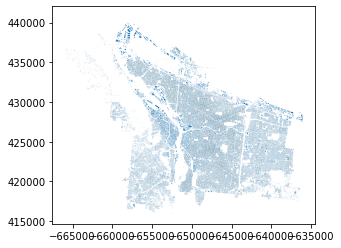

In [41]:
# Reprojecting polygons
b_rp = b.to_crs(proj)
b_rp.plot();

In [244]:
# Plot of all data
%matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
po_map = ax.imshow(po_ma, extent=po_ma_extent, cmap = 'YlOrBr', vmin=1, vmax=4)
f.colorbar(po_map, ax=ax)
n_bound = n_rp.plot(ax=ax, facecolor='None', edgecolor='k', alpha=0.5, lw=0.5)
build = b_rp.plot(ax=ax, alpha=0.5)
ax.set_title('Portland LSM and Building Footprint Map');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Part IV: Statistics applied to Building Footprint  
* Count number of polygons
* Explore the "BLDG_USE" column and create new DataFrame for each
* Calculate the area of the polygons
* Assign LS index to each polygon using centroid or median buffer

In [43]:
b_rp.shape

(247200, 43)

In [44]:
# sfr_idx = b_rp['BLDG_USE']=='Single Family Residential'

In [45]:
# b_rp[~sfr_idx]

In [46]:
b_rp['BLDG_USE'].value_counts()

Single Family Residential    223162
Multi Family Residential      16297
Not Set                         707
Commercial Office               628
Industrial                      528
Commercial Retail               384
Institutional                   159
Commercial Restaurant           134
Parking                         110
Vacant                           87
Commercial Hotel                 54
Institutional Religious          36
Commercial General                6
Commercial Grocery                3
TOWNHOUSE                         1
Name: BLDG_USE, dtype: int64

In [47]:
# b_rp['BLDG_TYPE'].value_counts()

In [48]:
# Mask clipped raster data
ls_ma = ma.masked_equal(po_ma, 0)
ls_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [49]:
# plt.hist(ls_ma, bins = 40)

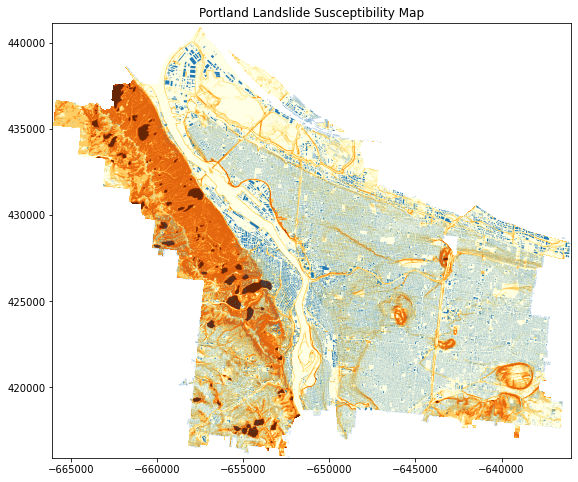

In [50]:
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'YlOrBr')
ax.set_title('Portland Landslide Susceptibility Map')
b_rp.plot(ax=ax);

### Isolate Residential Properties: Single and Multi family

In [51]:
b_sinfam = b_rp.loc[b_rp['BLDG_USE'] == 'Single Family Residential']
b_mulfam = b_rp.loc[b_rp['BLDG_USE'] == 'Multi Family Residential']

In [52]:
# Number of single and multi family buildings
print('The number of residential single familiy is', len(b_sinfam), 'and multi family is', len(b_mulfam))

The number of residential single familiy is 223162 and multi family is 16297


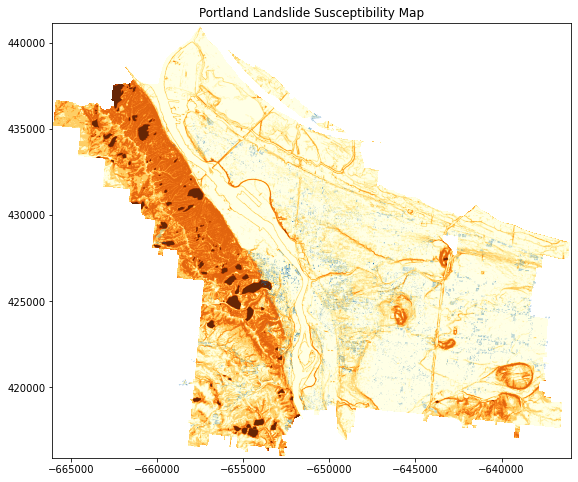

In [53]:
# Plot only single family
%matplotlib inline
f, ax = plt.subplots(figsize=(15,8))
ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'YlOrBr')
ax.set_title('Portland Landslide Susceptibility Map')
b_mulfam.plot(ax=ax);

In [54]:
# Reducing data to Building Type (BLDG_TYPE), Reported SQFT (BLDG_SQFT), and geometry feature
# b: building; sinfam: Single Family; r: reduced
b_sinfam_r = b_sinfam[['BLDG_TYPE', 'BLDG_USE', 'BLDG_SQFT', 'Shape_Leng', 'Shape_Area', 'geometry']].copy()
b_sinfam_r

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((-656639.503 434869.919, -65664..."
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((-656196.232 433091.942, -65619..."
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((-657700.854 434869.925, -65769..."
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((-659124.534 438513.441, -65913..."
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((-657465.590 435347.022, -65746..."
...,...,...,...,...,...,...
247189,None,Single Family Residential,NaN,277.545070,3734.001524,"MULTIPOLYGON (((-647889.354 432397.409, -64785..."
247190,None,Single Family Residential,220281.0,278.872117,4561.448768,"MULTIPOLYGON (((-647882.647 432459.279, -64784..."
247191,None,Single Family Residential,220281.0,659.749150,16329.394945,"MULTIPOLYGON (((-647846.259 432455.935, -64788..."
247192,None,Single Family Residential,287.0,64.345101,122.292974,"MULTIPOLYGON (((-648008.411 432034.668, -64798..."


In [55]:
b_mulfam_r = b_mulfam[['BLDG_TYPE', 'BLDG_USE', 'BLDG_SQFT', 'Shape_Leng', 'Shape_Area', 'geometry']].copy()
b_mulfam_r

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720..."
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812..."
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721..."
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698..."
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783..."
...,...,...,...,...,...,...
246600,Residential Condominiums,Multi Family Residential,4793.0,148.422676,910.446925,"MULTIPOLYGON (((-649151.050 434385.538, -64915..."
246624,Multiplex,Multi Family Residential,2127.0,91.605304,405.098531,"MULTIPOLYGON (((-649629.994 434168.968, -64963..."
246708,Duplex,Multi Family Residential,4401.0,86.084470,417.892769,"MULTIPOLYGON (((-649657.933 433542.758, -64963..."
246781,Duplex,Multi Family Residential,1272.0,75.750803,241.422792,"MULTIPOLYGON (((-650526.395 433589.694, -65052..."


### I. Working with Multi Family Residential buildings
#### Assign Landslide Susceptibility class exploring:
* Rio Sample
* Buffer
* Multipolygons shape

In [56]:
# geometry area and centroid // Adding columns
b_mulfam_r['area']= b_mulfam_r.geometry.area
b_mulfam_r['centroid']= b_mulfam_r.geometry.centroid

In [57]:
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542)
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348)
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727)
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277)
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969)


In [58]:
# Comparing differences in calculated area and reported area. Note that calculated area is in m^2
b_mulfam_r['area diff']= b_mulfam_r['BLDG_SQFT']/10.764 - b_mulfam_r['area']
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621


In [59]:
# Total area of multi familiy buildings
sum(b[b['BLDG_USE']=='Multi Family Residential'].geometry.area)

9485104.547665693

In [60]:
sum(b_mulfam_r['area'])

4657159.233899236

In [61]:
sqft_to_meter = b_mulfam_r['BLDG_SQFT']/10.764
sqft_to_meter.sum()

10528782.329988852

In [62]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid
b_sinfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((-656639.503 434869.919, -65664...",152.259690,POINT (-656645.201 434868.524)
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((-656196.232 433091.942, -65619...",59.746440,POINT (-656194.019 433086.841)
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((-657700.854 434869.925, -65769...",147.032627,POINT (-657705.449 434861.945)
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((-659124.534 438513.441, -65913...",216.215779,POINT (-659133.660 438508.118)
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((-657465.590 435347.022, -65746...",100.649739,POINT (-657466.030 435340.478)


In [63]:
b_mulfam_r['buffer_D'] = np.sqrt(2*b_mulfam_r['area']/np.pi)
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357,16.849603
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168,9.433064
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675,9.991008
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144,12.836003
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621,13.270685


In [67]:
# Defining buffer variables
c_mulfam = b_mulfam_r['centroid']
# c_mulfam_buff = b_mulfam_r['buffer_D']
buffer_D = b_mulfam_r['buffer_D']

In [68]:
b_mulfam_r['centroid_buffer']= c_mulfam.buffer(buffer_D)
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357,16.849603,"POLYGON ((-657183.138 435070.542, -657183.219 ..."
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168,9.433064,"POLYGON ((-658112.236 434728.348, -658112.282 ..."
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675,9.991008,"POLYGON ((-657198.910 431194.727, -657198.959 ..."
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144,12.836003,"POLYGON ((-656970.314 435455.277, -656970.376 ..."
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621,13.270685,"POLYGON ((-657821.594 434971.969, -657821.658 ..."


In [69]:
b_xy_test = [(pt.x, pt.y) for pt in c_mulfam.geometry]
# b_xy_test

In [70]:
# Rio sample
b_mulfam_sample = np.fromiter(src_proj.sample(b_xy_test), dtype=ls_ma.dtype) 

In [71]:
b_mulfam_sample.min()

0

In [72]:
b_mulfam_sample = b_mulfam_sample.astype(float)
b_mulfam_sample[b_mulfam_sample == src_proj.nodata] = np.nan

In [73]:
b_mulfam_r['ls_rio_sample'] = b_mulfam_sample
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357,16.849603,"POLYGON ((-657183.138 435070.542, -657183.219 ...",1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168,9.433064,"POLYGON ((-658112.236 434728.348, -658112.282 ...",1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675,9.991008,"POLYGON ((-657198.910 431194.727, -657198.959 ...",2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144,12.836003,"POLYGON ((-656970.314 435455.277, -656970.376 ...",2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621,13.270685,"POLYGON ((-657821.594 434971.969, -657821.658 ...",1.0


In [114]:
stats = ['count', 'mean', 'median','std']

In [115]:
# Zonal Stats
ls_zonal_stats = rasterstats.zonal_stats(b_mulfam_r['centroid_buffer'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [116]:
ls_zonal_stats_df = pd.DataFrame(ls_zonal_stats, index=b_mulfam_r['centroid_buffer'].index)
ls_zonal_stats_df.head()

,mean,count,std,median
97,1.000000,9,0.000000,1.0
102,1.000000,3,0.000000,1.0
105,2.000000,2,0.000000,2.0
132,2.166667,6,0.372678,2.0
174,1.000000,5,0.000000,1.0


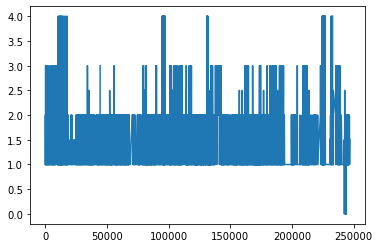

In [117]:
ls_zonal_stats_df['median'].plot();

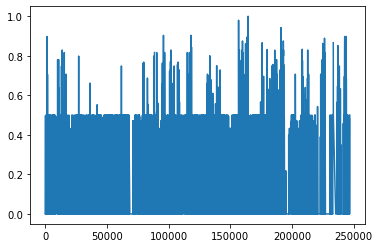

In [118]:
ls_zonal_stats_df['std'].plot();

In [78]:
b_mulfam_r['ls_class_mean'] = ls_zonal_stats_df['mean']
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample,ls_class_mean
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357,16.849603,"POLYGON ((-657183.138 435070.542, -657183.219 ...",1.0,1.000000
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168,9.433064,"POLYGON ((-658112.236 434728.348, -658112.282 ...",1.0,1.000000
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675,9.991008,"POLYGON ((-657198.910 431194.727, -657198.959 ...",2.0,2.000000
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144,12.836003,"POLYGON ((-656970.314 435455.277, -656970.376 ...",2.0,2.166667
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621,13.270685,"POLYGON ((-657821.594 434971.969, -657821.658 ...",1.0,1.000000


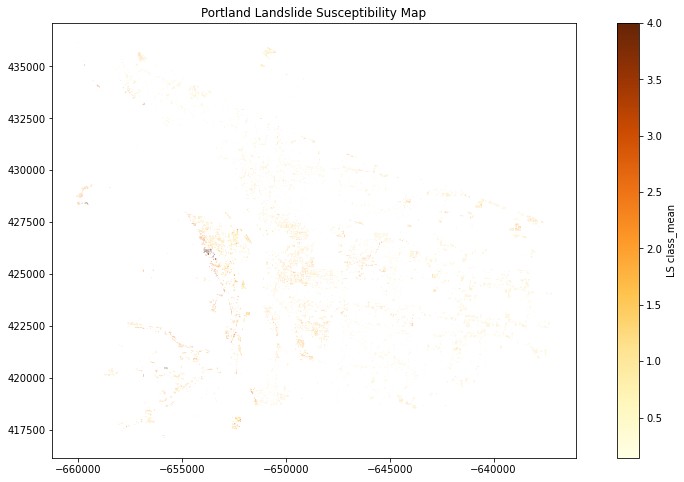

In [79]:
# %matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
# ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'gray')
ax.set_title('Portland Multi Family Residential Landslide Exposure')
b_mulfam_r.plot(ax=ax, column = 'ls_class_mean', cmap='YlOrBr', legend=True, legend_kwds={'label': 'LS class_mean'});

In [80]:
b_mulfam_r['ls_class_median'] = ls_zonal_stats_df['median']
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample,ls_class_mean,ls_class_median
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357,16.849603,"POLYGON ((-657183.138 435070.542, -657183.219 ...",1.0,1.000000,1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168,9.433064,"POLYGON ((-658112.236 434728.348, -658112.282 ...",1.0,1.000000,1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675,9.991008,"POLYGON ((-657198.910 431194.727, -657198.959 ...",2.0,2.000000,2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144,12.836003,"POLYGON ((-656970.314 435455.277, -656970.376 ...",2.0,2.166667,2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621,13.270685,"POLYGON ((-657821.594 434971.969, -657821.658 ...",1.0,1.000000,1.0


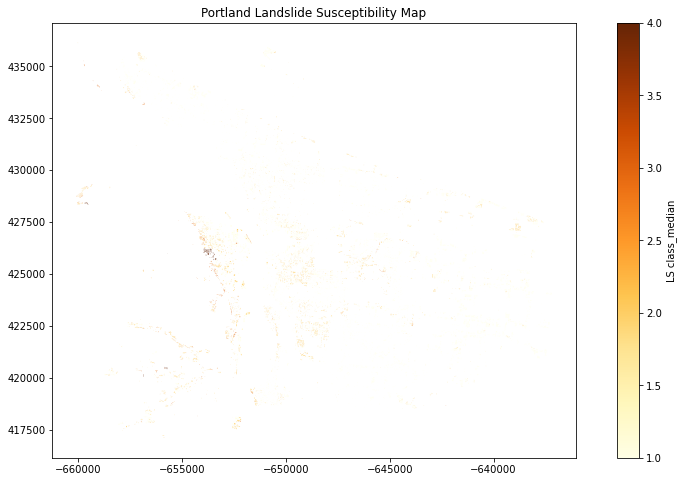

In [81]:
# %matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
# ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'gray')
ax.set_title('Portland Multi Family Residential Landslide Exposure')
b_mulfam_r.plot(ax=ax, column = 'ls_class_median', cmap='YlOrBr', vmin= 1.0, legend=True, legend_kwds={'label': 'LS class_median'});

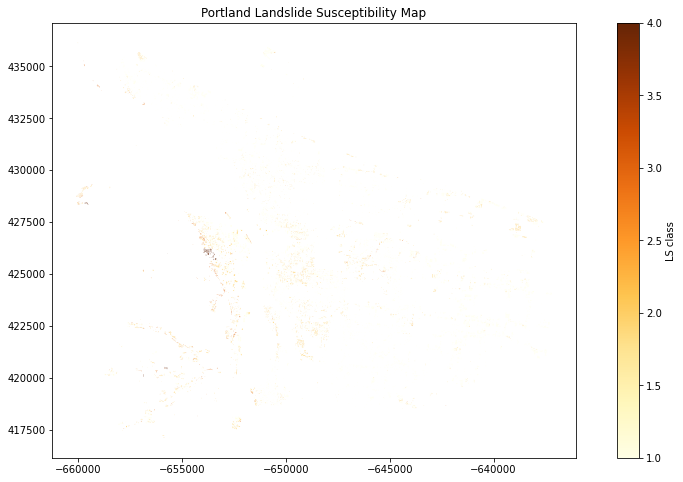

In [82]:
# Same exercise without buffer
# %matplotlib widget
f, ax = plt.subplots(figsize=(15,8))
# ax.imshow(ls_ma, extent=po_ma_extent, cmap = 'gray')
ax.set_title('Portland Multi Family Residential Landslide Exposure')
b_mulfam_r.plot(ax=ax, column = 'ls_rio_sample', cmap='YlOrBr', vmin=1.0, legend=True, legend_kwds={'label': 'LS class'});

In [83]:
b_mulfam_r['ls_rio_sample'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    2.0
246624    2.0
246708    1.0
246781    1.0
246957    1.0
Name: ls_rio_sample, Length: 16297, dtype: float64>

In [84]:
b_mulfam_r['ls_class_median'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    2.0
246624    2.0
246708    1.0
246781    1.0
246957    1.5
Name: ls_class_median, Length: 16297, dtype: float64>

<AxesSubplot:>

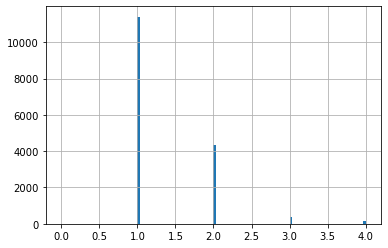

In [85]:
%matplotlib inline
b_mulfam_r['ls_rio_sample'].hist(bins=128)

In [86]:
idx_ma = b_mulfam_r['ls_rio_sample'] < 1.0
b_mulfam_r['ls_rio_sample'].count()

16297

In [87]:
# b_mulfam_r['ls_rio_sample'][idx_ma] =np.nan

In [88]:
b_mulfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_rio_sample,ls_class_mean,ls_class_median
97,Apartment Complex,Multi Family Residential,4801.0,167.466408,910.854747,"MULTIPOLYGON (((-657206.780 435092.166, -65720...",445.963426,POINT (-657199.988 435070.542),0.060357,16.849603,"POLYGON ((-657183.138 435070.542, -657183.219 ...",1.0,1.000000,1.0
102,Duplex,Multi Family Residential,3020.0,77.472361,285.440784,"MULTIPOLYGON (((-658121.658 434737.617, -65812...",139.773678,POINT (-658121.669 434728.348),140.791168,9.433064,"POLYGON ((-658112.236 434728.348, -658112.282 ...",1.0,1.000000,1.0
105,Duplex,Multi Family Residential,3367.0,74.369329,319.858534,"MULTIPOLYGON (((-657217.981 431197.495, -65721...",156.797258,POINT (-657208.901 431194.727),156.004675,9.991008,"POLYGON ((-657198.910 431194.727, -657198.959 ...",2.0,2.000000,2.0
132,Apartment Complex,Multi Family Residential,2784.0,116.154005,528.670379,"MULTIPOLYGON (((-656980.747 435463.529, -65698...",258.809055,POINT (-656983.150 435455.277),-0.169144,12.836003,"POLYGON ((-656970.314 435455.277, -656970.376 ...",2.0,2.166667,2.0
174,Multiplex,Multi Family Residential,2985.0,103.539271,564.981863,"MULTIPOLYGON (((-657847.953 434971.645, -65783...",276.634645,POINT (-657834.865 434971.969),0.678621,13.270685,"POLYGON ((-657821.594 434971.969, -657821.658 ...",1.0,1.000000,1.0


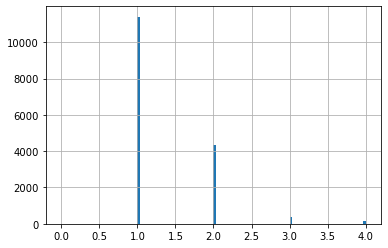

In [89]:
%matplotlib inline
b_mulfam_r['ls_rio_sample'].hist(bins=128);

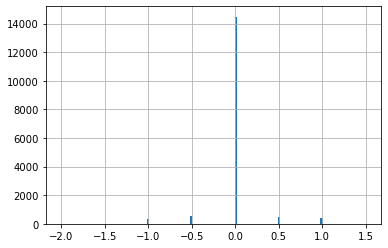

In [90]:
b_mulfam_r['median_vs_rio_sample'] = b_mulfam_r['ls_rio_sample'] - b_mulfam_r['ls_class_median']
b_mulfam_r['median_vs_rio_sample'].hist(bins=128);

In [91]:
b_mulfam_stats = b_mulfam_r.groupby('ls_rio_sample').agg('sum')
b_mulfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,area diff,buffer_D,ls_class_mean,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,
0.0,21282.0,6.004081e+02,3.476368e+03,1.701495e+03,2.756509e+02,80.560049,1.876190,0.0,0.0
1.0,76201106.0,1.199956e+06,6.534535e+06,3.208177e+06,3.872060e+06,140752.781356,12167.534252,11839.0,-522.0
2.0,32375799.0,4.717255e+05,2.595700e+06,1.274699e+06,1.734305e+06,55312.847750,7990.859253,8191.5,478.5
3.0,2914822.0,4.584070e+04,2.527730e+05,1.241562e+05,1.466374e+05,5327.551798,1102.280617,1129.0,77.0
4.0,1818804.0,1.533890e+04,9.862212e+04,4.842537e+04,1.205456e+05,1808.716788,514.206777,515.5,0.5


In [92]:
b_mulfam_stats['area'].sum()

4657159.233899192

In [93]:
b_mulfam_r['area'].sum()

4657159.233899201

In [94]:
b_mulfam_stats1 = b_mulfam_r.groupby('ls_class_median').agg('sum')
b_mulfam_stats1

,BLDG_SQFT,Shape_Leng,Shape_Area,area,area diff,buffer_D,ls_rio_sample,ls_class_mean,median_vs_rio_sample
ls_class_median,,,,,,,,,
0.0,21282.0,6.004081e+02,3.476368e+03,1.701495e+03,2.756509e+02,80.560049,0.0,1.876190,0.0
0.5,5822.0,1.964900e+02,1.105523e+03,5.410866e+02,-2.095696e-01,26.247088,3.0,1.500000,2.0
1.0,73758826.0,1.157703e+06,6.342806e+06,3.113977e+06,3.740587e+06,135717.710228,11205.0,11402.487924,323.0
1.5,4859296.0,8.217812e+04,4.010473e+05,1.969075e+05,2.545321e+05,10179.115244,1339.0,1360.122720,-18.5
2.0,29143858.0,4.254672e+05,2.373716e+06,1.165784e+06,1.541746e+06,49544.601475,7421.0,7282.211709,-229.0
2.5,510662.0,1.031376e+04,5.174790e+04,2.541513e+04,2.202653e+04,1238.799231,255.0,259.737500,-7.5
3.0,2484578.0,3.778742e+04,2.077059e+05,1.020116e+05,1.288114e+05,4391.534950,964.0,947.780935,-35.0
3.5,2501.0,1.565159e+02,4.753566e+02,2.335299e+02,-1.181351e+00,17.242275,7.0,7.000000,0.0
4.0,1834348.0,1.541008e+04,9.920600e+04,4.871207e+04,1.217030e+05,1816.170367,515.0,514.040110,-1.0


In [95]:
b_mulfam_stats1['area'].sum()

4655283.358143256

In [96]:
ls_ma_hist = np.ravel(ls_ma)

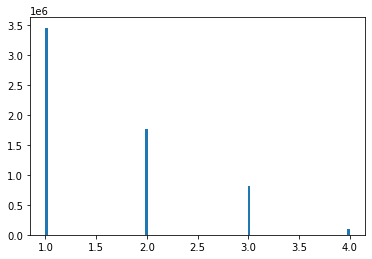

In [97]:
plt.hist(ls_ma_hist, bins=128)
plt.show()

In [98]:
ls_ma_hist.shape

(7641089,)

In [99]:
ls_ma.shape

(2531, 3019)

In [100]:
b_mulfam_stats.shape

(5, 9)

In [101]:
b_mulfam_r.shape

(16297, 15)

In [102]:
# geom_test = b_mulfam_r.loc[97].geometry

In [103]:
# geom_test_gdf = gpd.GeoSeries(geom_test)

In [104]:
# f, ax=plt.subplots()
# geom_test_gdf.plot(ax=ax)
# geom_test_gdf.centroid.buffer(15).plot(ax=ax, color='k', alpha=0.5);

In [105]:
po_ma_extent

(-666094.3467535608,
 -635953.3920386845,
 415904.70162660937,
 441173.58416498365)

In [107]:
# geom_test_gdf.total_bounds

In [108]:
# example_extent = (geom_test_gdf.total_bounds[0], geom_test_gdf.total_bounds[2], geom_test_gdf.total_bounds[1], geom_test_gdf.total_bounds[3])
# example_extent

In [119]:
ls_zonal_stats_2 = rasterstats.zonal_stats(b_mulfam_r['geometry'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [120]:
ls_zonal_stats_2_df = pd.DataFrame(ls_zonal_stats_2, index=b_mulfam_r['geometry'].index)
ls_zonal_stats_2_df.describe()

,mean,count,std,median
count,15331.000000,16297.000000,15331.000000,15331.000000
mean,1.350186,2.855924,0.089342,1.346683
std,0.536637,3.261132,0.187038,0.557308
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000
50%,1.000000,2.000000,0.000000,1.000000
75%,1.666667,3.000000,0.000000,2.000000
max,4.000000,69.000000,1.000000,4.000000


In [121]:
ls_zonal_stats_df.describe()

,mean,count,std,median
count,16189.000000,16297.000000,16189.000000,16189.000000
mean,1.345158,5.719458,0.141203,1.338872
std,0.512415,6.358826,0.215979,0.552442
min,0.142857,0.000000,0.000000,0.000000
25%,1.000000,3.000000,0.000000,1.000000
50%,1.000000,4.000000,0.000000,1.000000
75%,1.666667,7.000000,0.400000,2.000000
max,4.000000,132.000000,1.000000,4.000000


In [122]:
ls_zonal_stats_df['median'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    2.0
246624    2.0
246708    1.0
246781    1.0
246957    1.5
Name: median, Length: 16297, dtype: float64>

In [123]:
ls_zonal_stats_2_df['median'].value_counts

<bound method IndexOpsMixin.value_counts of 97        1.0
102       1.0
105       2.0
132       2.0
174       1.0
         ... 
246600    2.0
246624    2.0
246708    1.0
246781    1.0
246957    NaN
Name: median, Length: 16297, dtype: float64>

### II. Working with Single Family Residential buildings
#### Assign Landslide Susceptibility class exploring:
* Rio Sample
* Buffer
* Multipolygons shape

In [125]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid

In [128]:
# geometry area and centroid // Adding columns
b_sinfam_r['area']= b_sinfam_r.geometry.area
b_sinfam_r['centroid']= b_sinfam_r.geometry.centroid

In [130]:
c_sinfam = b_sinfam_r['centroid']
# Coordinates to pass rio sample
b_xy_sinfam = [(pt.x, pt.y) for pt in c_sinfam.geometry]

In [131]:
# rio sample
b_sinfam_sample = np.fromiter(src_proj.sample(b_xy_sinfam), dtype=ls_ma.dtype) 

In [132]:
b_sinfam_sample = b_sinfam_sample.astype(float)
b_sinfam_sample[b_sinfam_sample == src_proj.nodata] = np.nan

In [133]:
b_sinfam_r['ls_rio_sample'] = b_sinfam_sample
b_sinfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,ls_rio_sample
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((-656639.503 434869.919, -65664...",152.259690,POINT (-656645.201 434868.524),1.0
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((-656196.232 433091.942, -65619...",59.746440,POINT (-656194.019 433086.841),1.0
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((-657700.854 434869.925, -65769...",147.032627,POINT (-657705.449 434861.945),1.0
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((-659124.534 438513.441, -65913...",216.215779,POINT (-659133.660 438508.118),1.0
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((-657465.590 435347.022, -65746...",100.649739,POINT (-657466.030 435340.478),2.0


In [140]:
# Zonal Stats to 'geometry' attribute
ls_zonal_stats_sinfam_2 = rasterstats.zonal_stats(b_sinfam_r['geometry'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [135]:
ls_zonal_stats_df_sinfam_2 = pd.DataFrame(ls_zonal_stats_sinfam_2, index=b_sinfam_r['geometry'].index)
ls_zonal_stats_df_sinfam_2.head()

,mean,count,std,median
0,1.0,3,0.0,1.0
1,NaN,0,NaN,NaN
2,1.0,2,0.0,1.0
3,1.0,3,0.0,1.0
4,2.0,1,0.0,2.0


In [136]:
# Defining buffer
b_sinfam_r['buffer_D'] = np.sqrt(2*b_sinfam_r['area']/np.pi)
# Defining buffer variables
c_sinfam = b_sinfam_r['centroid']
buffer_D_sinfam = b_sinfam_r['buffer_D']
# Adding to the gdf columns
b_sinfam_r['centroid_buffer']= c_sinfam.buffer(buffer_D_sinfam)
b_sinfam_r.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,ls_rio_sample,buffer_D,centroid_buffer
0,House,Single Family Residential,1324.0,82.255414,310.967219,"MULTIPOLYGON (((-656639.503 434869.919, -65664...",152.259690,POINT (-656645.201 434868.524),1.0,9.845381,"POLYGON ((-656635.356 434868.524, -656635.403 ..."
1,Garage,Single Family Residential,554.0,44.618188,121.956227,"MULTIPOLYGON (((-656196.232 433091.942, -65619...",59.746440,POINT (-656194.019 433086.841),1.0,6.167314,"POLYGON ((-656187.852 433086.841, -656187.882 ..."
2,House,Single Family Residential,1384.0,81.154237,300.281235,"MULTIPOLYGON (((-657700.854 434869.925, -65769...",147.032627,POINT (-657705.449 434861.945),1.0,9.674910,"POLYGON ((-657695.774 434861.945, -657695.820 ..."
3,None,Single Family Residential,2325.0,84.873482,442.060692,"MULTIPOLYGON (((-659124.534 438513.441, -65913...",216.215779,POINT (-659133.660 438508.118),1.0,11.732316,"POLYGON ((-659121.928 438508.118, -659121.984 ..."
4,House,Single Family Residential,688.0,63.291208,205.587118,"MULTIPOLYGON (((-657465.590 435347.022, -65746...",100.649739,POINT (-657466.030 435340.478),2.0,8.004724,"POLYGON ((-657458.025 435340.478, -657458.064 ..."


In [137]:
# Zonal Stats to 'centroid buffer' attribute
ls_zonal_stats_sinfam = rasterstats.zonal_stats(b_sinfam_r['centroid_buffer'], ls_ma, \
                                           affine=po_ma_transform, nodata=src_proj.nodata, stats=stats)

In [138]:
ls_zonal_stats_df_sinfam_1 = pd.DataFrame(ls_zonal_stats_sinfam, index=b_sinfam_r['geometry'].index)
ls_zonal_stats_df_sinfam_1.head()

,mean,count,std,median
0,1.0,3,0.0,1.0
1,1.0,2,0.0,1.0
2,1.0,3,0.0,1.0
3,1.0,4,0.0,1.0
4,1.5,2,0.5,1.5


In [139]:
# Assign to a column
b_sinfam_r['ls_class_median'] = ls_zonal_stats_df_sinfam_1['median']

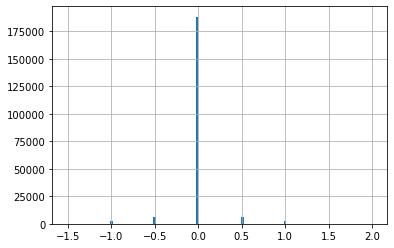

In [141]:
# Differences:
b_sinfam_r['median_vs_rio_sample'] = b_sinfam_r['ls_rio_sample'] - b_sinfam_r['ls_class_median']
b_sinfam_r['median_vs_rio_sample'].hist(bins=128);

In [157]:
b_sinfam_stats = b_sinfam_r.groupby('ls_rio_sample').agg('sum')
b_sinfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,
0.0,1729217.0,5.711749e+04,2.816756e+05,1.347198e+05,7.186844e+03,6.5,-6.5
1.0,397728611.0,1.168339e+07,6.201536e+07,3.041555e+07,1.474352e+06,153251.5,-4704.5
2.0,119536757.0,3.843609e+06,1.724931e+07,8.470275e+06,4.850920e+05,92694.0,3740.0
3.0,21554131.0,5.419702e+05,2.616958e+06,1.284058e+06,6.738926e+04,17489.0,778.0
4.0,3720978.0,1.244645e+05,5.923712e+05,2.908430e+05,1.521155e+04,5317.5,14.5


## V. INTERPRETATION
* Percent of residential buildings exposed to each class

In [158]:
# Using rio sample values:
b_mulfam_stats['% of area in ls_class'] = 100*round(b_mulfam_stats['area']/b_mulfam_stats['area'].sum(),2)
b_sinfam_stats['% of area in ls_class'] = 100*round(b_sinfam_stats['area']/b_sinfam_stats['area'].sum(),2)

In [172]:
# Merge both dataframe with concatenate
merge_stats = [b_mulfam_stats, b_sinfam_stats]
b_residential_concat = pd.concat(merge_stats, join="inner")
# b_residential_concat = b_mulfam_stats.append(b_sinfam_stats)

In [173]:
b_residential_concat

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class
ls_rio_sample,,,,,,,,
0.0,21282.0,6.004081e+02,3.476368e+03,1.701495e+03,8.056005e+01,0.0,0.0,0.0
1.0,76201106.0,1.199956e+06,6.534535e+06,3.208177e+06,1.407528e+05,11839.0,-522.0,69.0
2.0,32375799.0,4.717255e+05,2.595700e+06,1.274699e+06,5.531285e+04,8191.5,478.5,27.0
3.0,2914822.0,4.584070e+04,2.527730e+05,1.241562e+05,5.327552e+03,1129.0,77.0,3.0
4.0,1818804.0,1.533890e+04,9.862212e+04,4.842537e+04,1.808717e+03,515.5,0.5,1.0
0.0,1729217.0,5.711749e+04,2.816756e+05,1.347198e+05,7.186844e+03,6.5,-6.5,0.0
1.0,397728611.0,1.168339e+07,6.201536e+07,3.041555e+07,1.474352e+06,153251.5,-4704.5,75.0
2.0,119536757.0,3.843609e+06,1.724931e+07,8.470275e+06,4.850920e+05,92694.0,3740.0,21.0
3.0,21554131.0,5.419702e+05,2.616958e+06,1.284058e+06,6.738926e+04,17489.0,778.0,3.0


In [180]:
b_residential_concat['% of total in ls_class'] = 100*round(b_residential_concat['area']/b_residential_concat['area'].sum(),2)
b_residential_concat

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class,% of total in ls_class
ls_rio_sample,,,,,,,,,
0.0,21282.0,6.004081e+02,3.476368e+03,1.701495e+03,8.056005e+01,0.0,0.0,0.0,0.0
1.0,76201106.0,1.199956e+06,6.534535e+06,3.208177e+06,1.407528e+05,11839.0,-522.0,69.0,7.0
2.0,32375799.0,4.717255e+05,2.595700e+06,1.274699e+06,5.531285e+04,8191.5,478.5,27.0,3.0
3.0,2914822.0,4.584070e+04,2.527730e+05,1.241562e+05,5.327552e+03,1129.0,77.0,3.0,0.0
4.0,1818804.0,1.533890e+04,9.862212e+04,4.842537e+04,1.808717e+03,515.5,0.5,1.0,0.0
0.0,1729217.0,5.711749e+04,2.816756e+05,1.347198e+05,7.186844e+03,6.5,-6.5,0.0,0.0
1.0,397728611.0,1.168339e+07,6.201536e+07,3.041555e+07,1.474352e+06,153251.5,-4704.5,75.0,67.0
2.0,119536757.0,3.843609e+06,1.724931e+07,8.470275e+06,4.850920e+05,92694.0,3740.0,21.0,19.0
3.0,21554131.0,5.419702e+05,2.616958e+06,1.284058e+06,6.738926e+04,17489.0,778.0,3.0,3.0


In [181]:
b_residential_concat['% of total in ls_class'].sum()

100.0

<AxesSubplot:>

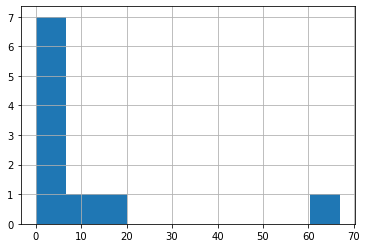

In [183]:
b_residential_stats['% of total in ls_class'].hist()

In [185]:
b_mulfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,area diff,buffer_D,ls_class_mean,ls_class_median,median_vs_rio_sample,% of area in ls_class
ls_rio_sample,,,,,,,,,,
0.0,21282.0,6.004081e+02,3.476368e+03,1.701495e+03,2.756509e+02,80.560049,1.876190,0.0,0.0,0.0
1.0,76201106.0,1.199956e+06,6.534535e+06,3.208177e+06,3.872060e+06,140752.781356,12167.534252,11839.0,-522.0,69.0
2.0,32375799.0,4.717255e+05,2.595700e+06,1.274699e+06,1.734305e+06,55312.847750,7990.859253,8191.5,478.5,27.0
3.0,2914822.0,4.584070e+04,2.527730e+05,1.241562e+05,1.466374e+05,5327.551798,1102.280617,1129.0,77.0,3.0
4.0,1818804.0,1.533890e+04,9.862212e+04,4.842537e+04,1.205456e+05,1808.716788,514.206777,515.5,0.5,1.0


In [162]:
b_sinfam_stats.head()

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class
ls_rio_sample,,,,,,,,
0.0,1729217.0,5.711749e+04,2.816756e+05,1.347198e+05,7.186844e+03,6.5,-6.5,0.0
1.0,397728611.0,1.168339e+07,6.201536e+07,3.041555e+07,1.474352e+06,153251.5,-4704.5,75.0
2.0,119536757.0,3.843609e+06,1.724931e+07,8.470275e+06,4.850920e+05,92694.0,3740.0,21.0
3.0,21554131.0,5.419702e+05,2.616958e+06,1.284058e+06,6.738926e+04,17489.0,778.0,3.0
4.0,3720978.0,1.244645e+05,5.923712e+05,2.908430e+05,1.521155e+04,5317.5,14.5,1.0


In [163]:
b_sinfam_stats['area'].sum()

40595446.77604674

In [164]:
b_sinfam_r['area'].sum()

40595446.7760468

In [165]:
b_mulfam_r['area'].sum()

4657159.233899201

In [166]:
b_mulfam_stats['area'].sum()

4657159.233899192

In [187]:
b_sinfam_stats_count = b_sinfam_r.groupby('ls_rio_sample').agg('count')
b_sinfam_stats_count.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,buffer_D,centroid_buffer,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,,,,
0.0,2,771,770,771,771,771,771,771,771,771,754,754
1.0,135806,162932,161277,162932,162932,162932,162932,162932,162932,162932,148547,148547
2.0,44831,51760,51315,51760,51760,51760,51760,51760,51760,51760,48217,48217
3.0,5474,6309,6267,6309,6309,6309,6309,6309,6309,6309,6089,6089
4.0,1138,1390,1377,1390,1390,1390,1390,1390,1390,1390,1333,1333


In [188]:
b_mulfam_stats_count = b_mulfam_r.groupby('ls_rio_sample').agg('count')
b_mulfam_stats_count.head()

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,area diff,buffer_D,centroid_buffer,ls_class_mean,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,,,,,,
0.0,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1.0,11200,11405,11404,11405,11405,11405,11405,11405,11404,11405,11405,11317,11317,11317
2.0,4252,4355,4354,4355,4355,4355,4355,4355,4354,4355,4355,4335,4335,4335
3.0,390,402,402,402,402,402,402,402,402,402,402,402,402,402
4.0,119,129,129,129,129,129,129,129,129,129,129,129,129,129


In [241]:
b_residential_stats_area = b_residential_concat.groupby('ls_rio_sample').agg('sum')
b_residential_stats_area

,BLDG_SQFT,Shape_Leng,Shape_Area,area,buffer_D,ls_class_median,median_vs_rio_sample,% of area in ls_class,% of total in ls_class
ls_rio_sample,,,,,,,,,
0.0,1750499.0,5.771790e+04,2.851520e+05,1.364212e+05,7.267404e+03,6.5,-6.5,0.0,0.0
1.0,473929717.0,1.288335e+07,6.854989e+07,3.362373e+07,1.615105e+06,165090.5,-5226.5,144.0,74.0
2.0,151912556.0,4.315335e+06,1.984501e+07,9.744974e+06,5.404049e+05,100885.5,4218.5,48.0,22.0
3.0,24468953.0,5.878109e+05,2.869731e+06,1.408214e+06,7.271681e+04,18618.0,855.0,6.0,3.0
4.0,5539782.0,1.398034e+05,6.909934e+05,3.392683e+05,1.702027e+04,5833.0,15.0,2.0,1.0


In [191]:
merge_stats_count = [b_mulfam_stats_count, b_sinfam_stats_count]
b_residential_concat_count = pd.concat(merge_stats_count, join="inner")
b_residential_stats_count = b_residential_concat_count.groupby('ls_rio_sample').agg('sum')
b_residential_stats_count

,BLDG_TYPE,BLDG_USE,BLDG_SQFT,Shape_Leng,Shape_Area,geometry,area,centroid,buffer_D,centroid_buffer,ls_class_median,median_vs_rio_sample
ls_rio_sample,,,,,,,,,,,,
0.0,8,777,776,777,777,777,777,777,777,777,760,760
1.0,147006,174337,172681,174337,174337,174337,174337,174337,174337,174337,159864,159864
2.0,49083,56115,55669,56115,56115,56115,56115,56115,56115,56115,52552,52552
3.0,5864,6711,6669,6711,6711,6711,6711,6711,6711,6711,6491,6491
4.0,1257,1519,1506,1519,1519,1519,1519,1519,1519,1519,1462,1462


In [193]:
b_residential_stats_count = 100*round(b_residential_concat_count['BLDG_USE']/b_residential_concat_count['BLDG_USE'].sum(),2)
b_residential_stats_count

ls_rio_sample
0.0     0.0
1.0     5.0
2.0     2.0
3.0     0.0
4.0     0.0
0.0     0.0
1.0    68.0
2.0    22.0
3.0     3.0
4.0     1.0
Name: BLDG_USE, dtype: float64

<ipython-input-238-e5b3709cbd5f>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbl)


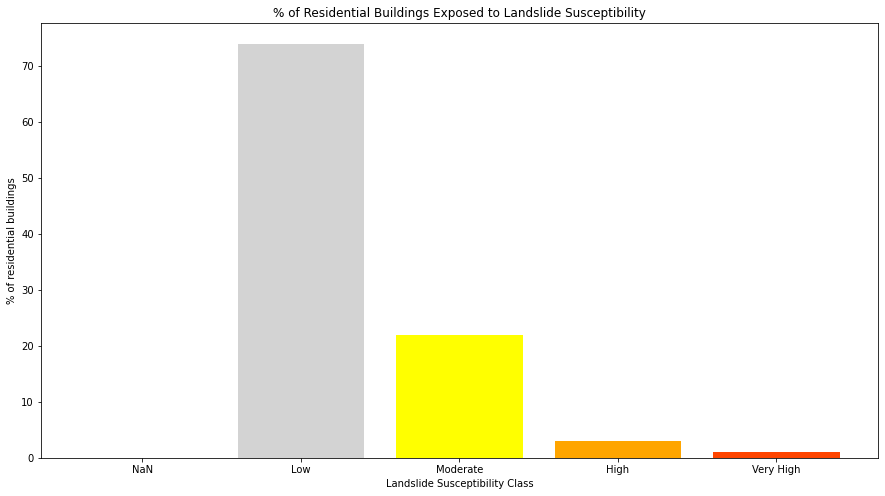

In [238]:
# Representing results
result = np.array(b_residential_stats['% of total in ls_class'])
x_axis = ([0,1,2,3,4])
lbl = (['', 'NaN', 'Low', 'Moderate', 'High', 'Very High'])
colors = ['k', 'lightgray','yellow','orange','orangered']
f, ax=plt.subplots(figsize=(15,8))
plt.bar(x_axis, result, color=colors, align='center')
ax.set_xticklabels(lbl)
plt.title('% of Residential Buildings Exposed to Landslide Susceptibility')
plt.xlabel('Landslide Susceptibility Class')
plt.ylabel('% of residential buildings');

In [243]:
b_residential_stats_area['% of total in ls_class'].describe

<bound method NDFrame.describe of ls_rio_sample
0.0     0.0
1.0    74.0
2.0    22.0
3.0     3.0
4.0     1.0
Name: % of total in ls_class, dtype: float64>

## Conclusions
* 74% of residential buildings fall under low susceptibility class
* 22% of residential buildings fall under Moderate susceptibility class
* 3% of residential buildings fall under High susceptibility class
* 1% of residential buildings fall under Very High susceptibility class

### Further Research
* Statistics based on Building types
* Using probability of landslide over time
* Economic impacts (Annual Loss)